In [1]:
import farabio
from farabio.data.biodatasets import ChestXrayDataset, HistocancerDataset, DSB18Dataset

In [2]:
_path_chest = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
_path_dsb = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
_path_histo = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"

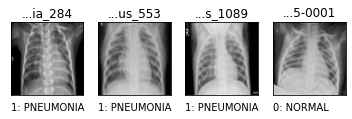

In [3]:
train_dataset = ChestXrayDataset(_path_chest)

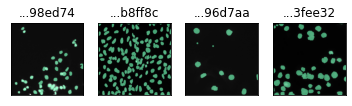

In [5]:
train_dataset = DSB18Dataset(_path_dsb)

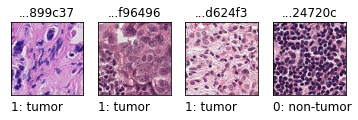

In [9]:
train_dataset = HistocancerDataset(_path_histo)